<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 5: Gravimetrie
# Geoid and gravity from spherical harmonics
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

We first import libraries we will need. This time, besides the standard `numpy` and `matplotlib`
libraries, we need special functions from the `scipy` package.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

----
## Read Stokes coefficients for geoid and gravity

We want to reconstruct geoid $N(\theta,\phi)$ and gravity maps $g(\theta,\phi)$ from 
Stokes coefficients $C_{nm}$, using the spherical harmonics $Y_{nm}(\theta,\phi)$:
$$
N(\theta,\phi) = \frac{1}{g_0} \frac{GM}{r} 
\sum\limits_{n=0}^{n_{max}} \sum\limits_{m=0}^{n} C_{nm} Y_{nm}(\theta,\phi)
$$

The Stokes coefficients $C_{nm}$ we read from the file `EIGEN2.nm` in the data directory, 
which contains the **coefficients** for the spherical harmonic reconstruction of the gravity model **EIGEN2**
from:

Reigber, Ch., Schwintzer, P., Neumayer, K.-H., Barthelmes, F., König, R., Förste, Ch., Balmino, G., Biancale, R., Lemoine, J.-M., Loyer, S., Bruinsma, S., Perosanz, F., Fayard, T.(2003): 
The CHAMP-only Earth Gravity Field Model EIGEN-2. Advances in Space Research 31(8), 1883-1888, 2003 
http://doi.org/10.1016/S0273-1177(03)00162-5

In [2]:
ls data; head data/EIGEN2.nm

EIGEN2.nm         TOPO.nm           topo.xyz
IGRF13.nm         igrf13coeffs.txt
0 0 0.100000000000E+01 0.000000000000E+00
1 0 0.000000000000E+00 0.000000000000E+00
2 0 -.484165815935E-03 0.000000000000E+00
3 0 0.957730216460E-06 0.000000000000E+00
4 0 0.539990690361E-06 0.000000000000E+00
5 0 0.683461067620E-07 0.000000000000E+00
6 0 -.149889934937E-06 0.000000000000E+00
7 0 0.906958785709E-07 0.000000000000E+00
8 0 0.492020424118E-07 0.000000000000E+00
9 0 0.283410132335E-07 0.000000000000E+00


Note that the Stokes coefficients $C_{nm}$ have a **cosine** and a **sine** term!

- We use the `loadtxt` module from the `numpy` package, skip the first line, because it is a header line.

- We then sort the entries into a 3D array `stokes` (our $C_{nm}$) for the different degree $n$ and order $m$ values.

- Note that we initially fill the array with `nan`, meaning **not a number**, to mark the positions
with $m>n$ as positions without data.

In [3]:
# open gravity model data file and read data
name1='Eigen2'
infile1='data/EIGEN2.nm'
data = np.loadtxt(fname=infile1,skiprows=0)
print(data.shape)
# sort Stokes coefficients into array stokes
nmax = 360
mmax = nmax
Cnm = np.zeros((nmax+1)*(mmax+1)*2).reshape((nmax+1),(mmax+1),2)
Cnm = Cnm*np.nan
for i in range(data.shape[0]):
    n = int(data[i,0])
    m = int(data[i,1])
    Cnm[n,m,0] = data[i,2]
    Cnm[n,m,1] = data[i,3]
    
# check first Stokes coefficients C_00 to C_20
n=0;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=1;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=2;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
    
# re-set Stokes coefficients C_00 and C_20 to zero (aka remove normal gravity)
Cnm[0,0,0] = 0.
Cnm[2,0,0] = 0.

# check first Stokes coefficients C_00 to C_20
n=0;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=1;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=2;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])

(7959, 4)
n= 0  m= 0 C_nm:  1.0 S_nm:  0.0
n= 1  m= 0 C_nm:  0.0 S_nm:  0.0
n= 2  m= 0 C_nm:  -0.000484165815935 S_nm:  0.0
n= 0  m= 0 C_nm:  0.0 S_nm:  0.0
n= 1  m= 0 C_nm:  0.0 S_nm:  0.0
n= 2  m= 0 C_nm:  0.0 S_nm:  0.0


----
## Define fundamental parameter and normal gravity

In [4]:
# fundamental parameter values
𝐺 = 6.67408e-11
M = 5.972e24
a = 6378160.
r = 6371000.

# for GGM05C gravity model ...
GM = 3.986004415E+14
r  = 6.378136300E+06
print(GM/r)
print(GM/r**2)

62494813.96313215
9.798287622535153


In [5]:
def g0(theta=0.):
    '''
    Normal gravity as a function of latitude
    returns gravity g0 in m/s2
    '''
    d2r = np.pi/180.
    g0  = 9.780318*(1.+0.0053024*(np.sin(theta*d2r))**2-0.0000058*(np.sin(2*theta*d2r))**2)
    return g0

print(g0())
print(g0(90))

9.780318
9.8321771581632


----
## Power spectrum

Next, we plot the power spectrum of the coefficients:
$$
P_n = \sum\limits_{m=0}^{n} \sqrt{C_{nm}^2 + S_{nm}^2}
$$

0.0 1e-07


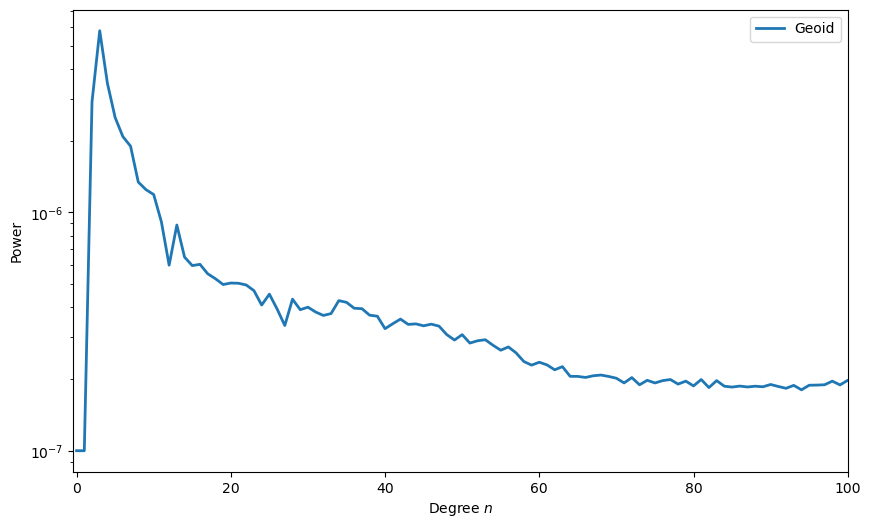

In [6]:
degree = np.zeros(nmax+1)
power = np.zeros(nmax+1)
for n in range(nmax+1):
    degree[n] = n
    power[n] = 1e-7
    for m in range(n+1):
        degree[n] = n
        power[n]  = power[n] + np.sqrt(Cnm[n,m,0]**2 + Cnm[n,m,1]**2)

print(degree[0],power[0])
plt.figure(figsize=(10,6))
plt.xlabel('Degree $n$')
plt.ylabel('Power')
plt.xlim([-0.5,100])
plt.semilogy(degree,power,linewidth=2,label='Geoid')
plt.legend()

----
## Reconstruct geoid and gravity

Define coordinates as sampling points:
- $\theta \in [0,180]$ co-latitude
- $\phi \in [0,360]$ longitude

In [7]:
# define coordinates (in radiants)
d2r   = np.pi/180.
#dlong = 101; dcolat = 51
dlong = 201; dcolat = 101
colat = np.linspace(0, np.pi, dcolat)
long  = np.linspace(0, 2*np.pi, dlong)
print(colat.shape)
colat, long = np.meshgrid(colat, long)
print(colat.shape)

(101,)
(201, 101)


Text(0.5, 1.0, 'Robinson Projection')

/opt/miniconda3/envs/python_pygimli/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


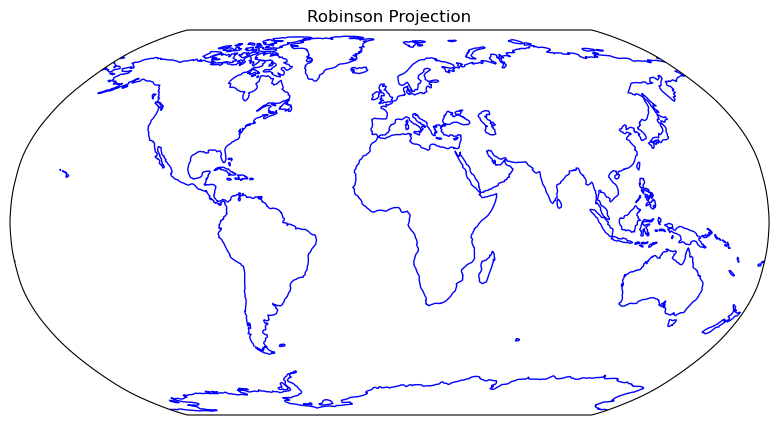

In [8]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(color='blue')
plt.title("Robinson Projection")

Re-assemble **geoid** by summing up over spherical harmonics:
$$
N(\theta,\phi) = \frac{1}{g_0} \frac{GM}{r} 
\sum\limits_{n=0}^{n_{max}} \sum\limits_{m=0}^{n} C_{nm} Y_{nm}(\theta,\phi)
$$

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
np.sqrt(1/4/np.pi)

0.28209479177387814

(201, 101)


Text(0, 0.5, 'Geoid anomaly [m]')

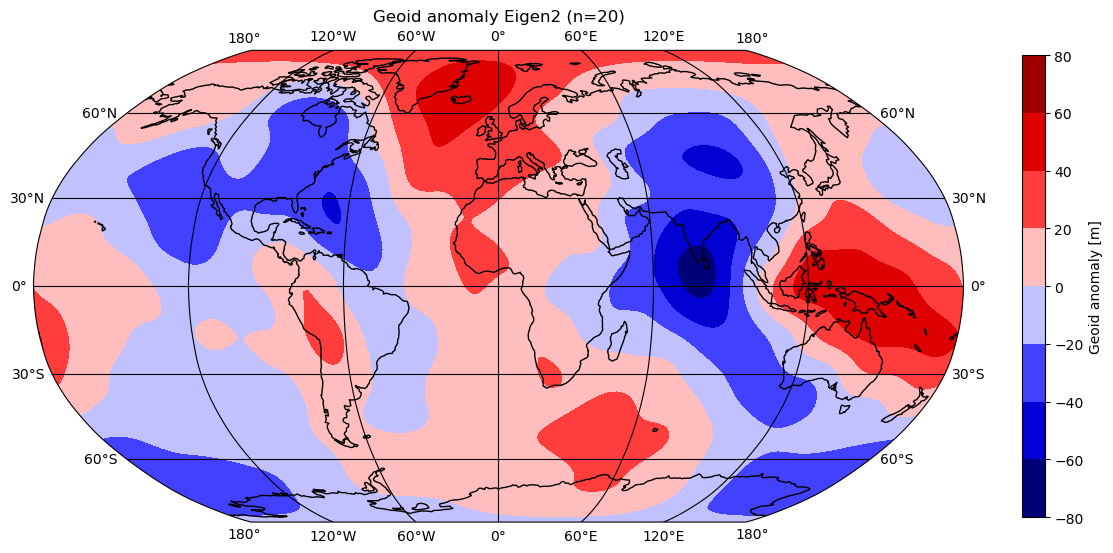

In [11]:
n = 20
m = n
geoid = np.zeros(dlong*dcolat).reshape(dlong,dcolat)
print(geoid.shape)

for n in range(n+1):
    for m in range(n+1):
        Ynm = sph_harm(m, n, long, colat) * np.sqrt(4*np.pi) # reverse 4pi normalisation to geodetic norm
        geoid = geoid + (a/r)**n * (Cnm[n,m,0]*Ynm.real + Cnm[n,m,1]*Ynm.imag)
geoid = GM/r / g0(90-colat/d2r) * geoid 
        
# define figure, map projection, coastlines, and gridlines
fig = plt.figure(figsize=(15,10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines(color='black')
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='black')
# plot geoid map on top, add color bar
axs.set_title('Geoid anomaly '+name1+' (n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,geoid,transform=ccrs.PlateCarree(),cmap='seismic')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('Geoid anomaly [m]')

Re-assemble **gravity** by summing up over spherical harmonics:
$$
\Delta g(\theta,\phi) = \frac{GM}{r^2}
\sum\limits_{n=0}^{n_{max}} \sum\limits_{m=0}^{n} (n+1) C_{nm} Y_{nm}(\theta,\phi)
$$

(201, 101)


Text(0, 0.5, 'Gravity anomaly [mGal]')

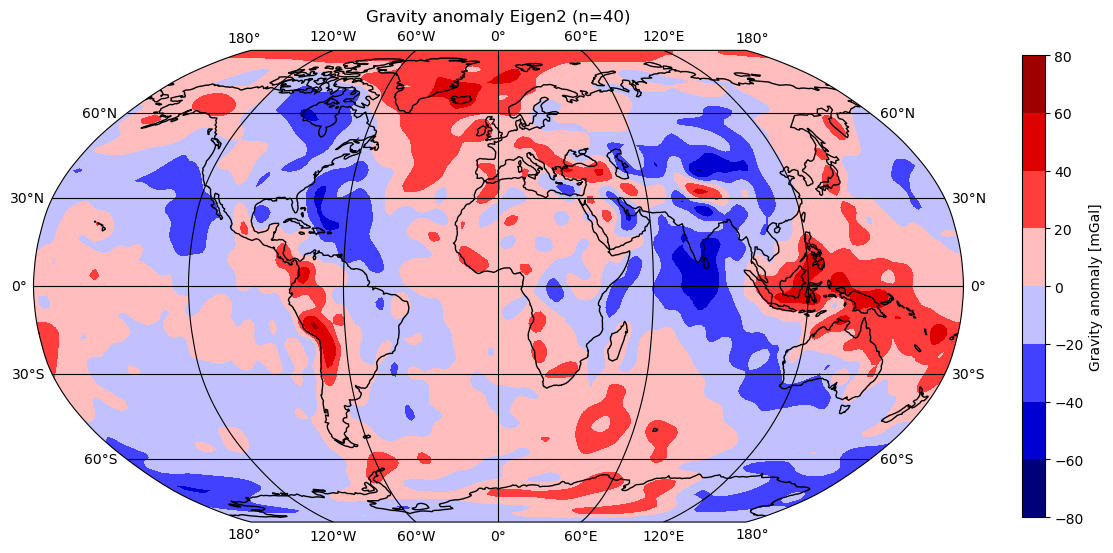

In [12]:
n = 40
m = n
gravity = np.zeros(dlong*dcolat).reshape(dlong,dcolat)
print(gravity.shape)

for n in range(n+1):
    for m in range(n+1):
        Ynm = sph_harm(m, n, long, colat) * np.sqrt(4*np.pi) # reverse 4pi normalisation to geodetic norm
        gravity = gravity + (n+1)*(Cnm[n,m,0]*Ynm.real + Cnm[n,m,1]*Ynm.imag)
gravity = 1.e5 * GM/r**2 * gravity

# define figure, map projection, coastlines, and gridlines
fig = plt.figure(figsize=(15,10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines(color='black')
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='black')
# plot geoid map on top, add color bar
axs.set_title('Gravity anomaly '+name1+' (n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,gravity,transform=ccrs.PlateCarree(),cmap='seismic')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('Gravity anomaly [mGal]')


... done